In [1]:
import os
import hashlib
from pathlib import Path
import argparse

import torch
from torch.utils.data import DataLoader
import pandas as pd
import lightning.pytorch as pl
from FUCCIDataset import FUCCIDatasetInMemory, ReferenceChannelDatasetInMemory, FUCCIChannelDatasetInMemory
from LightningModules import AutoEncoder, FUCCIDataModule


In [2]:
##########################################################################################
# Set up environment and parser
##########################################################################################

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"
torch.set_float32_matmul_precision('medium')


from dataclasses import dataclass
@dataclass
class EmbeddingArgs:
    model: str
    channels: str
    data: str
args = EmbeddingArgs(
    model="/data/ishang/fucci_vae/fucci_256_512_2023_05_24_05_47/",
    channels="reference",
    # data="/home/ishang/implicit-cell-model/FUCCI-dev-data")
    data="/data/ishang/Fucci-dataset-v3_filtered/")

devices = 8

In [3]:
if not Path(args.model).exists():
    raise ValueError("Checkpoint path does not exist.")
args.model = Path(args.model)
if not args.model.is_file():
    if args.model / "lightning_logs" in args.model.iterdir():
        args.model = args.model / "lightning_logs"
        if len(list(args.model.iterdir())) > 1:
            raise ValueError("Multiple model directories were found in lightning_logs.")
        else:
            args.model = list(args.model.iterdir())[0]
    else:
        raise ValueError("Model path does not contain lightning_logs directory.")

if not Path(args.data).exists():
    raise ValueError("Data path does not exist.")
args.data = Path(args.data)

if args.channels not in ["reference", "fucci", "total"]:
    raise ValueError("Model must be one of: reference, fucci, total")

if args.channels == "total":
    raise NotImplementedError("Total channels not trained yet.")


def img_hash(image):
    return hashlib.blake2b(image.numpy().tobytes()).hexdigest()

if args.data / "index.csv" not in args.data.iterdir():
    if args.channels == "reference":
        dataset = ReferenceChannelDatasetInMemory(args.data, imsize=256)
    elif args.channels == "fucci":
        dataset = FUCCIDatasetInMemory(args.data, imsize=256)
    cache = []
    for i in range(len(dataset)):
        exp_dir, cell_index = dataset.image_exp_index(i)
        cache.append({
            "index": i,
            "hash": img_hash(dataset[i]),
            "directory": str(exp_dir[1]),
            "cell_index": cell_index
        })
    cache = pd.DataFrame(cache)
    cache.to_csv(args.data / "index.csv")

else:
    cache = pd.read_csv(args.data / "index.csv")

In [4]:
model = AutoEncoder.load_from_checkpoint(args.model)
dm = FUCCIDataModule(args.data, args.channels, imsize=256, batch_size=16, num_workers=8)

/home/ishang/implicit-cell-model/FUCCIDataset.py:107: UserWarning: Training split /data/ishang/Fucci-dataset-v3_filtered/batch_indices_5.pt is not a directory
  warnings.warn(f"Training split {split} is not a directory")
/home/ishang/implicit-cell-model/FUCCIDataset.py:107: UserWarning: Training split /data/ishang/Fucci-dataset-v3_filtered/batch_indices_1.pt is not a directory
  warnings.warn(f"Training split {split} is not a directory")
/home/ishang/implicit-cell-model/FUCCIDataset.py:107: UserWarning: Training split /data/ishang/Fucci-dataset-v3_filtered/predictions_3.pt is not a directory
  warnings.warn(f"Training split {split} is not a directory")
/home/ishang/implicit-cell-model/FUCCIDataset.py:107: UserWarning: Training split /data/ishang/Fucci-dataset-v3_filtered/reference_embeddings.pt is not a directory
  warnings.warn(f"Training split {split} is not a directory")
/home/ishang/implicit-cell-model/FUCCIDataset.py:107: UserWarning: Training split /data/ishang/Fucci-dataset-v3_f

In [5]:
import torch
from lightning.pytorch.callbacks import BasePredictionWriter

class CustomWriter(BasePredictionWriter):

    def __init__(self, output_dir, write_interval):
        super().__init__(write_interval)
        self.output_dir = output_dir

    def write_on_epoch_end(self, trainer, pl_module, predictions, batch_indices):
        # this will create N (num processes) files in `output_dir` each containing
        # the predictions of it's respective rank
        torch.save(predictions, os.path.join(self.output_dir, f"predictions_{trainer.global_rank}.pt"))

        # optionally, you can also save `batch_indices` to get the information about the data index
        # from your prediction data
        torch.save(batch_indices, os.path.join(self.output_dir, f"batch_indices_{trainer.global_rank}.pt"))


pred_writer = CustomWriter(output_dir=args.data, write_interval="epoch")

In [6]:
trainer = pl.Trainer(accelerator="gpu", devices=devices, callbacks=[pred_writer])
# trainer = pl.Trainer(accelerator="cpu", callbacks=[pred_writer])
predictions = trainer.predict(model, datamodule=dm, return_predictions=False)

# add predictions to cache under name f"{channel}_embedding"
if f"{args.channels}_embedding" not in cache.columns:
    cache[f"{args.channels}_embedding"] = None

# for batch in predictions:
#     for i, image in enumerate(batch):
#         cache.loc[cache["index"] == i, f"{args.channels}_embedding"] = image.numpy().tolist()
# dataloader = DataLoader(dataset, batch_size=16, num_workers=8, persistent_workers=True, shuffle=False)
# with torch.no_grad():
    # for batch in iter(dm.predict_dataloader()):
    # for batch in iter(dataloader):
    #     batch.to("cuda")
    #     predictions = model(batch)
    #     print(predictions.shape)
    #     for i, embedding in enumerate(predictions):
    #         print(i)
    #         print(embedding)
    #         image = batch[i]
    #         cache.loc[cache["hash"] == img_hash(image), f"{args.channels}_embedding"] = embedding.numpy().tolist()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/8
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/8
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/8
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/8
Initializing distributed: GLOBAL_RANK: 4, MEMBER: 5/8
Initializing distributed: GLOBAL_RANK: 6, MEMBER: 7/8
Initializing distributed: GLOBAL_RANK: 5, MEMBER: 6/8
Initializing distributed: GLOBAL_RANK: 7, MEMBER: 8/8
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 8 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 5 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 7 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 

Predicting: 0it [00:00, ?it/s]

In [7]:
predictions_0 = torch.load(args.data / "predictions_0.pt")
batch_indices_0 = torch.load(args.data / "batch_indices_0.pt")
print(len(predictions_0))
print(len(predictions_0[0]))
print(len(predictions_0[1]))
print(predictions_0[0][0].shape)
print(predictions_0[0][1].shape)
print(batch_indices_0[0])

436
2
2
torch.Size([16, 2, 256, 256])
torch.Size([16, 2, 512])
[[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120], [128, 136, 144, 152, 160, 168, 176, 184, 192, 200, 208, 216, 224, 232, 240, 248], [256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336, 344, 352, 360, 368, 376], [384, 392, 400, 408, 416, 424, 432, 440, 448, 456, 464, 472, 480, 488, 496, 504], [512, 520, 528, 536, 544, 552, 560, 568, 576, 584, 592, 600, 608, 616, 624, 632], [640, 648, 656, 664, 672, 680, 688, 696, 704, 712, 720, 728, 736, 744, 752, 760], [768, 776, 784, 792, 800, 808, 816, 824, 832, 840, 848, 856, 864, 872, 880, 888], [896, 904, 912, 920, 928, 936, 944, 952, 960, 968, 976, 984, 992, 1000, 1008, 1016], [1024, 1032, 1040, 1048, 1056, 1064, 1072, 1080, 1088, 1096, 1104, 1112, 1120, 1128, 1136, 1144], [1152, 1160, 1168, 1176, 1184, 1192, 1200, 1208, 1216, 1224, 1232, 1240, 1248, 1256, 1264, 1272], [1280, 1288, 1296, 1304, 1312, 1320, 1328, 1336, 1344, 1352, 1360, 1368, 1376, 1384, 1392, 1400]

In [8]:
# predictions are a list of tensors, each tensor is the predictions of a batch
# batch_indices are is a list of list of lists, each list of lists is the batch indices of an epoch
# for prediction we will only have one epoch, so we only need the first list of lists

predictions = []
embeddings = []
batch_indices = []
for i in range(devices):
    predictions.append(torch.load(args.data / f"predictions_{i}.pt"))
    batch_indices.append(torch.load(args.data / f"batch_indices_{i}.pt")[0])

def flatten_one(l):
    return [item for sublist in l for item in sublist]

print(len(predictions))
print(len(batch_indices))

predictions = flatten_one(predictions)
batch_indices = flatten_one(batch_indices)
print(len(predictions))
print(len(batch_indices))

print(predictions[1][0].shape)

embeddings = []
for batch in predictions:
    embeddings.append(batch[1])
print(len(embeddings))
embeddings = flatten_one(embeddings)
batch_indices = flatten_one(batch_indices)
print(len(embeddings))
print(len(batch_indices))

8
8
3488
3488
torch.Size([16, 2, 256, 256])
3488
55777
55777


In [9]:
import numpy as np
embeddings = torch.stack(embeddings)
print(embeddings.shape)
torch.save(embeddings, args.data / f"{args.channels}_embeddings.pt")
np.save(args.data / f"{args.channels}_indices.npy", np.asarray(batch_indices))

torch.Size([55777, 2, 512])


In [10]:
import numpy as np

predictions = torch.load(args.data / f"{args.channels}_embeddings.pt")
indices = np.load(args.data / f"{args.channels}_indices.npy")

# Update the cache file maybe? Maybe order the predictions or something so you don't need an indices file?

[0.22850114 0.08938671 0.06395252 0.04952362 0.04443254 0.03694605
 0.03513589 0.03201043 0.02525771 0.02361718 0.02264607 0.02210785
 0.01929065 0.01746635 0.01513481 0.01485464 0.014521   0.01304707
 0.01283063 0.01134639 0.01105343 0.01004546 0.00912557 0.00895315
 0.0087968  0.00814262 0.00780778 0.00738762 0.00706021 0.00647474
 0.00633638 0.00592753]
[1795.589   1123.0503   949.92993  835.9281   791.796    722.0159
  704.10626  672.06067  596.9799   577.2671   565.2742   558.5165
  521.7185   496.4366   462.11627  457.819    452.64847  429.06128
  425.48737  400.12128  394.922    376.48502  358.83334  355.42728
  352.31006  338.95718  331.91473  322.8606   315.62515  302.25522
  299.00848  289.201  ]
(32, 512)


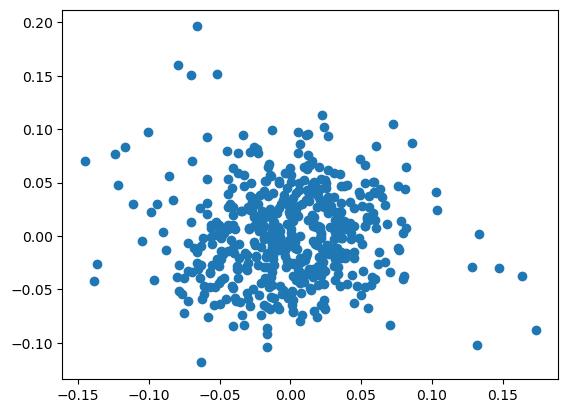

In [11]:
# select 100 random elements and do PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

indices = np.random.choice(len(predictions), 100)
embeddings = predictions[indices, 0, :].numpy()
pca = PCA(n_components=32)
pca.fit(embeddings)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(pca.components_.shape)

# plot the first 2 components
plt.clf()
plt.title(f"PCA of FUCCI {args.channels} embeddings")
plt.scatter(pca.components_[0], pca.components_[1])
plt.show()

plt.clf()
plt.title(f"Bar chart of FUCCI {args.channels} PCA components CDF")
plt.bar(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
plt.show()